In [156]:
using TSML
using TSML.Utils
using TSML.TSMLTypes
using TSML.TSMLTransformers
using TSML.Statifiers
using TSML.DataReaders
using TSML.Monotonicers
using TSML.Monotonicers: ismonotonic

using DataFrames
using Dates
using Random

## Introduce some missing data

In [157]:
Random.seed!(123)
dt=[missing;rand(1:10,3);missing;missing;missing;rand(1:5,3)]
dat = DataFrame(Date= DateTime(2017,12,31,1):Dates.Hour(1):DateTime(2017,12,31,10) |> collect,Value = dt)

,Date,Value
,DateTime,Int64⍰
1,2017-12-31T01:00:00,missing
2,2017-12-31T02:00:00,5
3,2017-12-31T03:00:00,3
4,2017-12-31T04:00:00,2
5,2017-12-31T05:00:00,missing
6,2017-12-31T06:00:00,missing
7,2017-12-31T07:00:00,missing
8,2017-12-31T08:00:00,2
9,2017-12-31T09:00:00,1


## Get statistics including blocks of missing data

In [159]:
statfier = Statifier(Dict(:processmissing=>true))
fit!(statfier,dat)
res=transform!(statfier,dat)
show(res,allcols=true)

1×26 DataFrame
│ Row │ TStart              │ TEnd                │ SFreq   │ count │ max   │
│     │ DateTime            │ DateTime            │ Float64 │ Int64 │ Int64 │
├─────┼─────────────────────┼─────────────────────┼─────────┼───────┼───────┤
│ 1   │ 2017-12-31T01:00:00 │ 2017-12-31T10:00:00 │ 0.9     │ 6     │ 5     │

│ Row │ min   │ median  │ mean    │ q1      │ q2      │ q25     │ q75     │
│     │ Int64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 1     │ 2.5     │ 3.0     │ 1.5     │ 2.0     │ 2.0     │ 4.5     │

│ Row │ q8      │ q9      │ kurtosis │ skewness │ variation │ entropy  │
│     │ Float64 │ Float64 │ Float64  │ Float64  │ Float64   │ Float64  │
├─────┼─────────┼─────────┼──────────┼──────────┼───────────┼──────────┤
│ 1   │ 5.0     │ 5.0     │ -1.46939 │ 0.280566 │ 0.557773  │ -22.1628 │

│ Row │ autocor  │ pacf     │ bmedian │ bmean   │ bq25    │ bq75    │ bmin

## Try real data; aggregate by hour

In [160]:
fname = joinpath(dirname(pathof(TSML)),"../data/testdata.csv")
csvfilter = DataReader(Dict(:filename=>fname,:dateformat=>"dd/mm/yyyy HH:MM"))
valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valnner = DateValNNer(Dict(:dateinterval=>Dates.Hour(1)))
stfier = Statifier(Dict(:processmissing=>true))

Statifier(nothing, Dict(:processmissing=>true))

## Get statistics including blocks of missing data

In [161]:
mpipeline1 = Pipeline(Dict(
  :transformers => [csvfilter,valgator,stfier]
 )
)
fit!(mpipeline1)
respipe1 = transform!(mpipeline1)
show(respipe1,allcols=true)

1×26 DataFrame
│ Row │ TStart              │ TEnd                │ SFreq    │ count │ max     │
│     │ DateTime            │ DateTime            │ Float64  │ Int64 │ Float64 │
├─────┼─────────────────────┼─────────────────────┼──────────┼───────┼─────────┤
│ 1   │ 2014-01-01T00:00:00 │ 2015-01-01T00:00:00 │ 0.999886 │ 3830  │ 18.8    │

│ Row │ min     │ median  │ mean    │ q1      │ q2      │ q25     │ q75     │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 8.5     │ 10.35   │ 11.557  │ 9.9     │ 10.0    │ 10.0    │ 12.3    │

│ Row │ q8      │ q9      │ kurtosis │ skewness │ variation │ entropy    │
│     │ Float64 │ Float64 │ Float64  │ Float64  │ Float64   │ Float64    │
├─────┼─────────┼─────────┼──────────┼──────────┼───────────┼────────────┤
│ 1   │ 13.0    │ 16.0    │ 0.730635 │ 1.41283  │ 0.200055  │ -1.09145e5 │

│ Row │ autocor │ pacf    │ bmedian │ bmean   

## Try imputing and get statistics

In [162]:
mpipeline2 = Pipeline(Dict(
  :transformers => [csvfilter,valgator,valnner,stfier]
 )
)
fit!(mpipeline2)
respipe2 = transform!(mpipeline2)
show(respipe2,allcols=true)

1×26 DataFrame
│ Row │ TStart              │ TEnd                │ SFreq    │ count │ max     │
│     │ DateTime            │ DateTime            │ Float64  │ Int64 │ Float64 │
├─────┼─────────────────────┼─────────────────────┼──────────┼───────┼─────────┤
│ 1   │ 2014-01-01T00:00:00 │ 2015-01-01T00:00:00 │ 0.999886 │ 8761  │ 18.8    │

│ Row │ min     │ median  │ mean    │ q1      │ q2      │ q25     │ q75     │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 8.5     │ 10.0    │ 11.1362 │ 9.95    │ 10.0    │ 10.0    │ 11.5    │

│ Row │ q8      │ q9      │ kurtosis │ skewness │ variation │ entropy    │
│     │ Float64 │ Float64 │ Float64  │ Float64  │ Float64   │ Float64    │
├─────┼─────────┼─────────┼──────────┼──────────┼───────────┼────────────┤
│ 1   │ 12.0    │ 14.95   │ 2.37274  │ 1.87452  │ 0.187997  │ -2.36714e5 │

│ Row │ autocor │ pacf    │ bmedian │ bmean   

### Monotonicer

In [163]:
regularfile = joinpath(dirname(pathof(TSML)),"../data/typedetection/regular.csv")
monofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/monotonic.csv")
dailymonofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/dailymonotonic.csv")
regularfilecsv = DataReader(Dict(:filename=>regularfile,:dateformat=>"dd/mm/yyyy HH:MM"))
monofilecsv = DataReader(Dict(:filename=>monofile,:dateformat=>"dd/mm/yyyy HH:MM"))
dailymonofilecsv = DataReader(Dict(:filename=>dailymonofile,:dateformat=>"dd/mm/yyyy HH:MM"))

valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valnner = DateValNNer(Dict(:dateinterval=>Dates.Hour(1)))
stfier = Statifier(Dict(:processmissing=>true))
mono = Monotonicer(Dict());

In [164]:
regpipeline = Pipeline(Dict(
  :transformers => [regularfilecsv,valgator,valnner]
 )
)
fit!(regpipeline)
regulardf=transform!(regpipeline)
first(regulardf,10)

,Date,Value
,DateTime,Float64⍰
1,2014-01-01T01:00:00,4.5
2,2014-01-01T02:00:00,4.35
3,2014-01-01T03:00:00,4.05
4,2014-01-01T04:00:00,4.45
5,2014-01-01T05:00:00,4.2
6,2014-01-01T06:00:00,5.1
7,2014-01-01T07:00:00,5.15
8,2014-01-01T08:00:00,4.3
9,2014-01-01T09:00:00,4.45


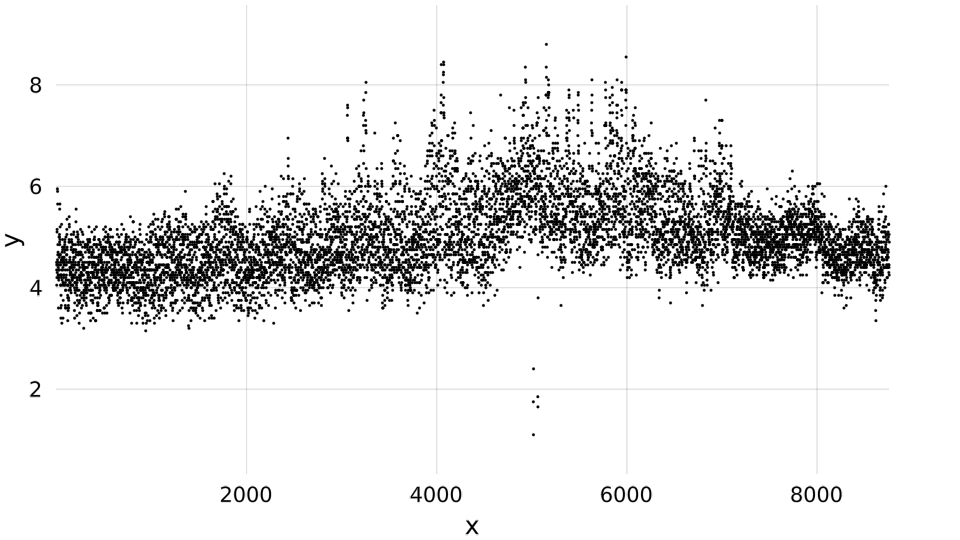

In [165]:
using Makie
using StatsMakie
using AbstractPlotting

regulardf[:Value] = convert(Array{Float64},regulardf[:Value])
scatter(regulardf[:Value],markersize=30)

In [171]:
monopipeline = Pipeline(Dict(
  :transformers => [monofilecsv,valgator,valnner,mono]
 )
)
fit!(monopipeline)
monodf=transform!(monopipeline)
first(monodf,10)

,Date,Value
,DateTime,Float64
1,2016-01-06T17:00:00,230.0
2,2016-01-06T18:00:00,230.0
3,2016-01-06T19:00:00,264.0
4,2016-01-06T20:00:00,258.0
5,2016-01-06T21:00:00,244.0
6,2016-01-06T22:00:00,254.0
7,2016-01-06T23:00:00,242.0
8,2016-01-07T00:00:00,240.0
9,2016-01-07T01:00:00,240.0


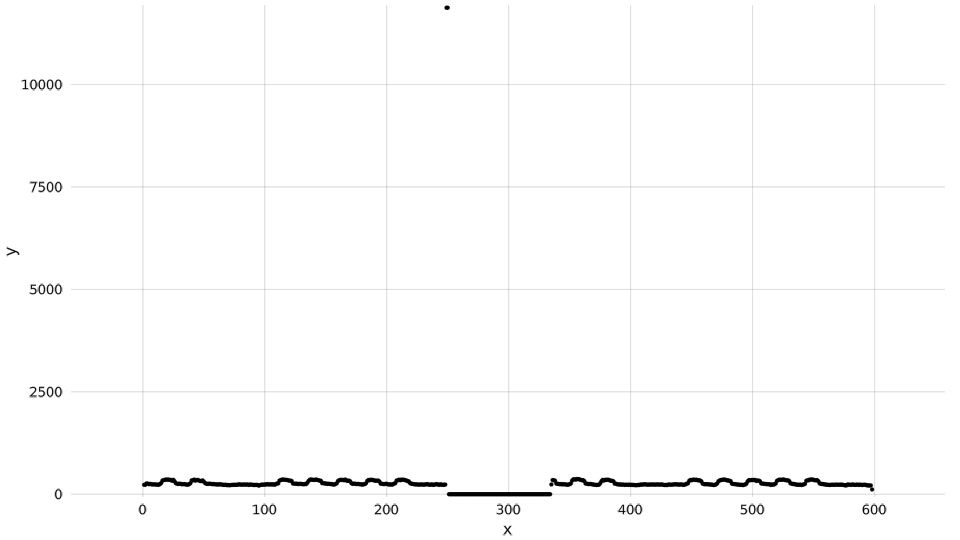

In [173]:
monodf[:Value] = convert(Array{Float64},monodf[:Value])
scatter(monodf[:Value],markersize=100)

In [168]:
dailymonopipeline = Pipeline(Dict(
  :transformers => [dailymonofilecsv,valgator,valnner,mono]
 )
)
fit!(dailymonopipeline)
dailymonodf=transform!(dailymonopipeline)
first(dailymonodf,10)

,Date,Value
,DateTime,Float64
1,2019-02-10T12:00:00,2.35
2,2019-02-10T13:00:00,2.35
3,2019-02-10T14:00:00,0.205
4,2019-02-10T15:00:00,0.205
5,2019-02-10T16:00:00,0.205
6,2019-02-10T17:00:00,0.18
7,2019-02-10T18:00:00,0.94
8,2019-02-10T19:00:00,0.24
9,2019-02-10T20:00:00,0.24


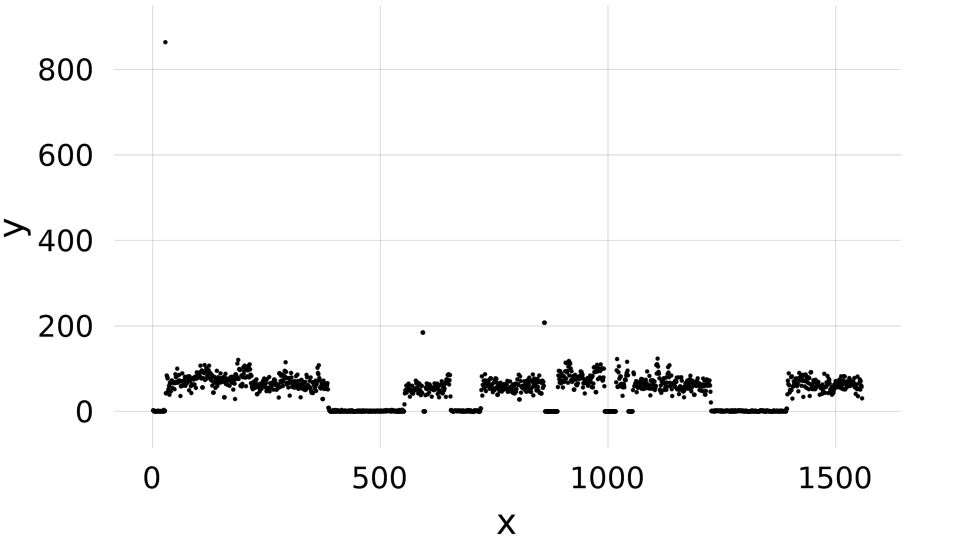

In [174]:
dailymonodf[:Value] = convert(Array{Float64},dailymonodf[:Value])
scatter(dailymonodf[:Value],markersize=10)